# 삼성전자 주가를 RNN으로 예측해보기

---

### 데이터 확인

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [60]:
# GPU 혹은 CPU 선택
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [62]:
# 1. 데이터 불러오기
df = yf.download('005930.KS', start='2000-01-01', end=None)
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,005930.KS,005930.KS,005930.KS,005930.KS,005930.KS
Date,,,,,
2000-01-04,4405.235352,4405.235352,4080.790849,4325.926695,74195000
2000-01-05,4023.110840,4369.184891,3979.851584,4181.728113,74680000
2000-01-06,4051.951904,4167.309966,4023.112389,4145.680329,54390000
2000-01-07,3994.270996,4087.999377,3864.493238,4008.690747,40305000
2000-01-10,4160.097168,4160.097168,4023.109566,4037.529314,46880000
...,...,...,...,...,...
2025-01-21,53500.000000,54300.000000,53300.000000,53700.000000,13535702
2025-01-22,54300.000000,54400.000000,53100.000000,53400.000000,18341991


df가 가진 각 컬럼의 의미:

Open: 주식 시장이 열릴 때의 주가

High: 해당 기간 동안의 최고 주가

Low: 해당 기간 동안의 최저 주가

Close: 주식 시장이 닫힐 때의 주가

Volume: 거래량

In [63]:
# 칼럼 이름 정렬(편의상 Open, High, Low, Volume 순으로 정리하고 Close는 예측 대상)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
print(df.head())

                  Close         High          Low         Open    Volume
Date                                                                    
2000-01-04  4405.235352  4405.235352  4080.790849  4325.926695  74195000
2000-01-05  4023.110840  4369.184891  3979.851584  4181.728113  74680000
2000-01-06  4051.951904  4167.309966  4023.112389  4145.680329  54390000
2000-01-07  3994.270996  4087.999377  3864.493238  4008.690747  40305000
2000-01-10  4160.097168  4160.097168  4023.109566  4037.529314  46880000


In [64]:
# 2. 슬라이딩 윈도우 함수
def create_dataset(data, window_size=30, step_size=1):
    X, y = [], []
    for i in range(0, len(data) - window_size, step_size):
        # window_size 길이만큼 X 만들기
        X.append(data.iloc[i:i + window_size])
        # 그 다음 시점(30일 이후)의 Close를 y로 사용
        y.append(data.iloc[i + window_size]['Close'])
    return pd.concat(X), pd.Series(y)

# 예측에 사용할 Feature: 'Open', 'High', 'Low', 'Volume'
# 예측 대상: 'Close'
# 주의: 아래에서 X에 'Close'를 넣지 않고, 대신 'High'를 넣습니다. (원하시는 컬럼 구성에 맞게 조정)
# 일반적으로 'Close'를 빼고 ['Open','High','Low','Volume']만 입력 feature로 쓰면,
# 'Close'는 y(정답)로만 쓰게 됩니다.
feature_cols = ['Open', 'High', 'Low', 'Volume']
data = df[feature_cols + ['Close']]  # 마지막에 'Close'를 붙여놓은 형태

window_size = 30
step_size = 1
X_df, y_df = create_dataset(data[feature_cols + ['Close']], window_size, step_size)

# X_df는 (samples * window_size, feature 수 + 1) 형태이므로,
# 우리가 실제 Feature로 삼고자 하는 건 ['Open','High','Low','Volume'] 4개
# 마지막에 있는 'Close'(5번째 col)는 y를 얻기 위해 남겨둔 것이므로, 실제 X에서 제거 필요
X_only_feature = X_df[feature_cols]

# 넘파이 변환 및 3차원 형태로 재구성 (samples, timesteps, features)
num_samples = len(X_only_feature) // window_size
X = X_only_feature.values.reshape(num_samples, window_size, len(feature_cols))
y = y_df.values

print("X.shape:", X.shape)  # (samples, 30, 4)
print("y.shape:", y.shape)  # (samples,)

X.shape: (6249, 30, 4)
y.shape: (6249,)


In [65]:
# 3. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [66]:
# 4. 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# X: 3D -> 2D reshape -> scaling -> 3D 복원
X_train_2d = X_train.reshape(-1, X_train.shape[-1])  # (samples*30, 4)
X_test_2d  = X_test.reshape(-1, X_test.shape[-1])    # (samples*30, 4)

X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
X_test_scaled_2d  = scaler_X.transform(X_test_2d)

X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_test_scaled  = X_test_scaled_2d.reshape(X_test.shape)

# y: 1D -> 2D -> scaling -> 다시 1D
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [67]:
# 5. PyTorch Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_scaled, y_train_scaled)
test_dataset  = TimeSeriesDataset(X_test_scaled,  y_test_scaled)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [68]:
# 6. RNN 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(RNNModel, self).__init__()
        # batch_first=True -> 입력: (batch, seq_len, input_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x.shape: (batch, seq_len, input_dim)
        out, hidden = self.rnn(x)  # out: (batch, seq_len, hidden_dim)
        # 마지막 time step의 은닉 상태
        out = out[:, -1, :]       # (batch, hidden_dim)
        out = self.fc(out)        # (batch, output_dim)
        return out

# 모델, 손실함수, 옵티마이저
input_dim = len(feature_cols)  # 4
hidden_dim = 50
output_dim = 1

model = RNNModel(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
# 7. 학습/검증 데이터 분할(Train 내부에서 Val 20%)
X_train_, X_val_, y_train_, y_val_ = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)
train_dataset_ = TimeSeriesDataset(X_train_, y_train_)
val_dataset_   = TimeSeriesDataset(X_val_,   y_val_)
train_loader_  = DataLoader(train_dataset_, batch_size=batch_size, shuffle=True)
val_loader_    = DataLoader(val_dataset_,   batch_size=batch_size, shuffle=False)

# MAE 계산 함수
def calculate_mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))


In [70]:
# 8. 학습 루프
num_epochs = 50

train_losses = []
val_losses   = []
train_maes   = []
val_maes     = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    running_mae  = 0.0
    for X_batch, y_batch in train_loader_:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()  # (batch,)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        running_mae  += calculate_mae(outputs, y_batch).item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader_.dataset)
    epoch_mae  = running_mae  / len(train_loader_.dataset)

    # --- Validation ---
    model.eval()
    val_running_loss = 0.0
    val_running_mae  = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader_:
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            val_outputs = model(X_val).squeeze()
            val_loss    = criterion(val_outputs, y_val)
            val_mae_val = calculate_mae(val_outputs, y_val)

            val_running_loss += val_loss.item()    * X_val.size(0)
            val_running_mae  += val_mae_val.item() * X_val.size(0)

    val_epoch_loss = val_running_loss / len(val_loader_.dataset)
    val_epoch_mae  = val_running_mae  / len(val_loader_.dataset)

    train_losses.append(epoch_loss)
    train_maes.append(epoch_mae)
    val_losses.append(val_epoch_loss)
    val_maes.append(val_epoch_mae)

    if (epoch+1) % 10 == 0:
        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train MAE: {epoch_mae:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f}, Val MAE: {val_epoch_mae:.4f}")

[Epoch 10/50] Train Loss: 0.0001, Train MAE: 0.0065 | Val Loss: 0.0001, Val MAE: 0.0054
[Epoch 20/50] Train Loss: 0.0001, Train MAE: 0.0058 | Val Loss: 0.0001, Val MAE: 0.0049
[Epoch 30/50] Train Loss: 0.0001, Train MAE: 0.0059 | Val Loss: 0.0001, Val MAE: 0.0054
[Epoch 40/50] Train Loss: 0.0001, Train MAE: 0.0058 | Val Loss: 0.0001, Val MAE: 0.0053
[Epoch 50/50] Train Loss: 0.0001, Train MAE: 0.0055 | Val Loss: 0.0001, Val MAE: 0.0051


In [71]:
# 9. 테스트 세트 성능 평가
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(X_batch).squeeze()
        test_preds.append(pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

test_preds    = np.concatenate(test_preds)
test_targets  = np.concatenate(test_targets)

mse_scaled = np.mean((test_preds - test_targets)**2)
mae_scaled = np.mean(np.abs(test_preds - test_targets))
print(f"Test MSE (scaled): {mse_scaled:.4f}")
print(f"Test MAE (scaled): {mae_scaled:.4f}")

# 스케일링 복원
test_preds_reshaped    = test_preds.reshape(-1, 1)
test_preds_inversed    = scaler_y.inverse_transform(test_preds_reshaped).flatten()
test_targets_reshaped  = test_targets.reshape(-1, 1)
test_targets_inversed  = scaler_y.inverse_transform(test_targets_reshaped).flatten()

mae_restored = np.mean(np.abs(test_preds_inversed - test_targets_inversed))
print(f"Test MAE (Restored): {mae_restored:.4f}")

print("\n[일부 결과 비교]")
for i in range(5):
    print(f"Actual: {test_targets_inversed[i]:.2f}, Predicted: {test_preds_inversed[i]:.2f}")


Test MSE (scaled): 0.0001
Test MAE (scaled): 0.0051
Test MAE (Restored): 436.3983

[일부 결과 비교]
Actual: 8624.42, Predicted: 8505.44
Actual: 5025.28, Predicted: 5537.50
Actual: 22028.23, Predicted: 21825.53
Actual: 7309.00, Predicted: 7459.94
Actual: 43215.93, Predicted: 44775.40


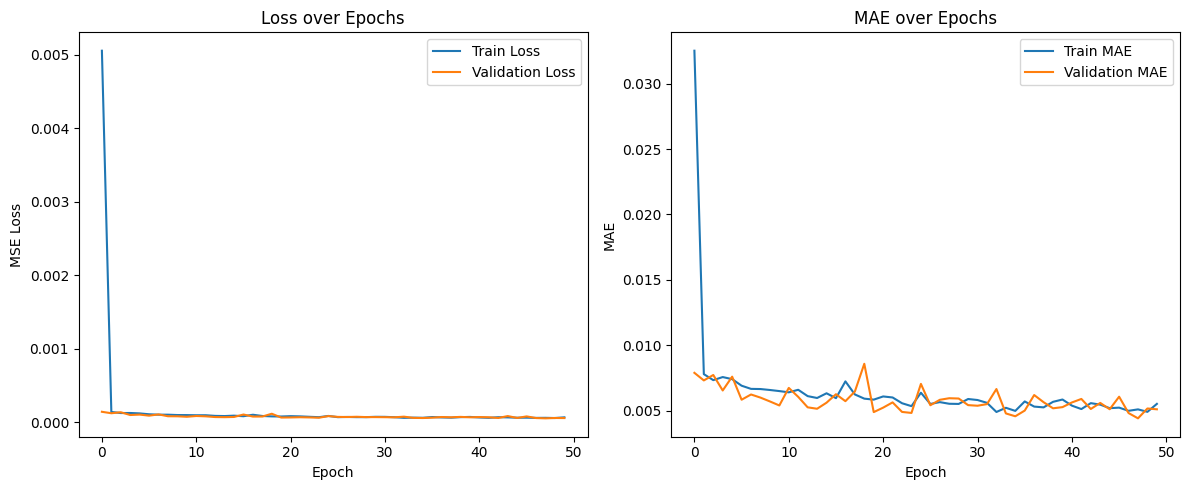

In [72]:
# 10. 학습 곡선 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes,   label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [73]:
# 11. "가장 최근 30일" 데이터를 통한 다음날 주가 예측
# ------------------------------------------------
# 실제 예측을 위해서 df에서 마지막 30일치('Open','High','Low','Volume')를 꺼내서
# 모델에 넣어 다음날의 'Close'를 예측합니다.

model.eval()
with torch.no_grad():
    # df의 마지막 30일 데이터를 가져옵니다 (4개 feature)
    recent_30_days = df.iloc[-30:][['Open', 'High', 'Low', 'Volume']].values
    # 위에서 사용한 scaler_X로 스케일링
    recent_30_days_scaled = scaler_X.transform(recent_30_days)
    # (1, 30, 4) 형태로 변환
    recent_30_days_scaled = recent_30_days_scaled.reshape(1, window_size, len(feature_cols))

    # PyTorch Tensor로 변환 후 모델 추론
    recent_30_days_tensor = torch.tensor(recent_30_days_scaled, dtype=torch.float32).to(device)
    predicted_close_scaled = model(recent_30_days_tensor).cpu().numpy()  # (1,1) 형태

    # 스케일링 복원
    predicted_close = scaler_y.inverse_transform(predicted_close_scaled).flatten()

    print(f"\n[다음날 종가 예측]")
    print(f"삼성전자의 다음날 주가는: {predicted_close[0]:.2f}원 (예측)")


[다음날 종가 예측]
삼성전자의 다음날 주가는: 52250.03원 (예측)
